In [1]:
import sys 
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torch_geometric
from models import training_utils, prediction_utils
from exploration import explor_utils
from torch_geometric.nn import SAGEConv

In [2]:
results_folder = "../optimization/results/v2/"
data_folder = f"/biodata/nyanovsky/datasets/dti/processed/v2/"

walk_with_features = pd.read_csv(results_folder+"sage_features_comp.csv")

In [293]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


node_df = pd.read_csv(data_folder+"dti_tensor_df.csv",index_col=0)

gene_feature_dict = training_utils.load_feature_dict(data_folder+"prot_features_64.txt", data_folder+"prot_features_ids.txt", 
                                                    node_df, "gene")

Text(0.5, 1.0, 'SAGE- top 400')

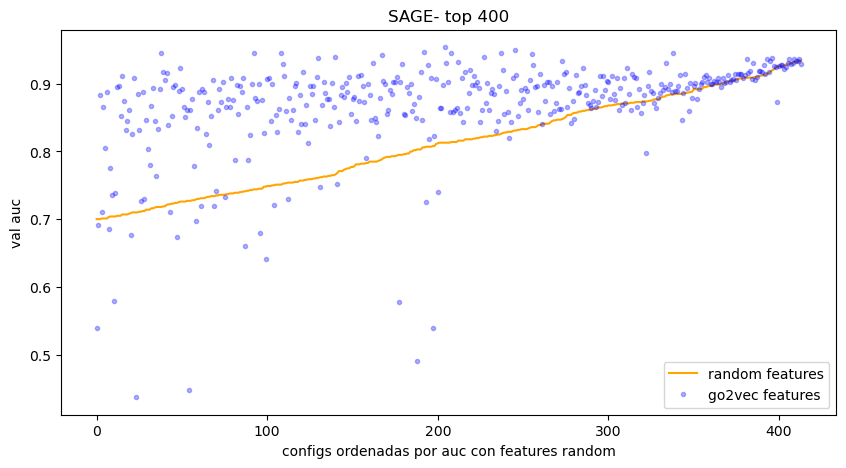

In [295]:
random_feats_aucs = walk_with_features["val_auc"].values
go2vec_feats_aucs = walk_with_features["val_auc_with_features"].values
idxs = np.argsort(random_feats_aucs)


plt.figure(figsize=(10,5))
plt.plot(random_feats_aucs[idxs], label="random features", color="orange")
plt.plot(go2vec_feats_aucs[idxs], ".", label="go2vec features", color="blue",alpha=0.3)
plt.xlabel("configs ordenadas por auc con features random")
plt.ylabel("val auc")
plt.legend()
plt.title("SAGE- top 400")

In [296]:
hps = ['feature_dim', 'pre_process_layers', 'post_process_layers',
       'layer_connectivity', 'hidden_channels', 'batch_norm', 'dropout',
       'macro_aggregation', 'L2_norm', 'msg_passing_layers',
       'normalize_output', 'aggr']

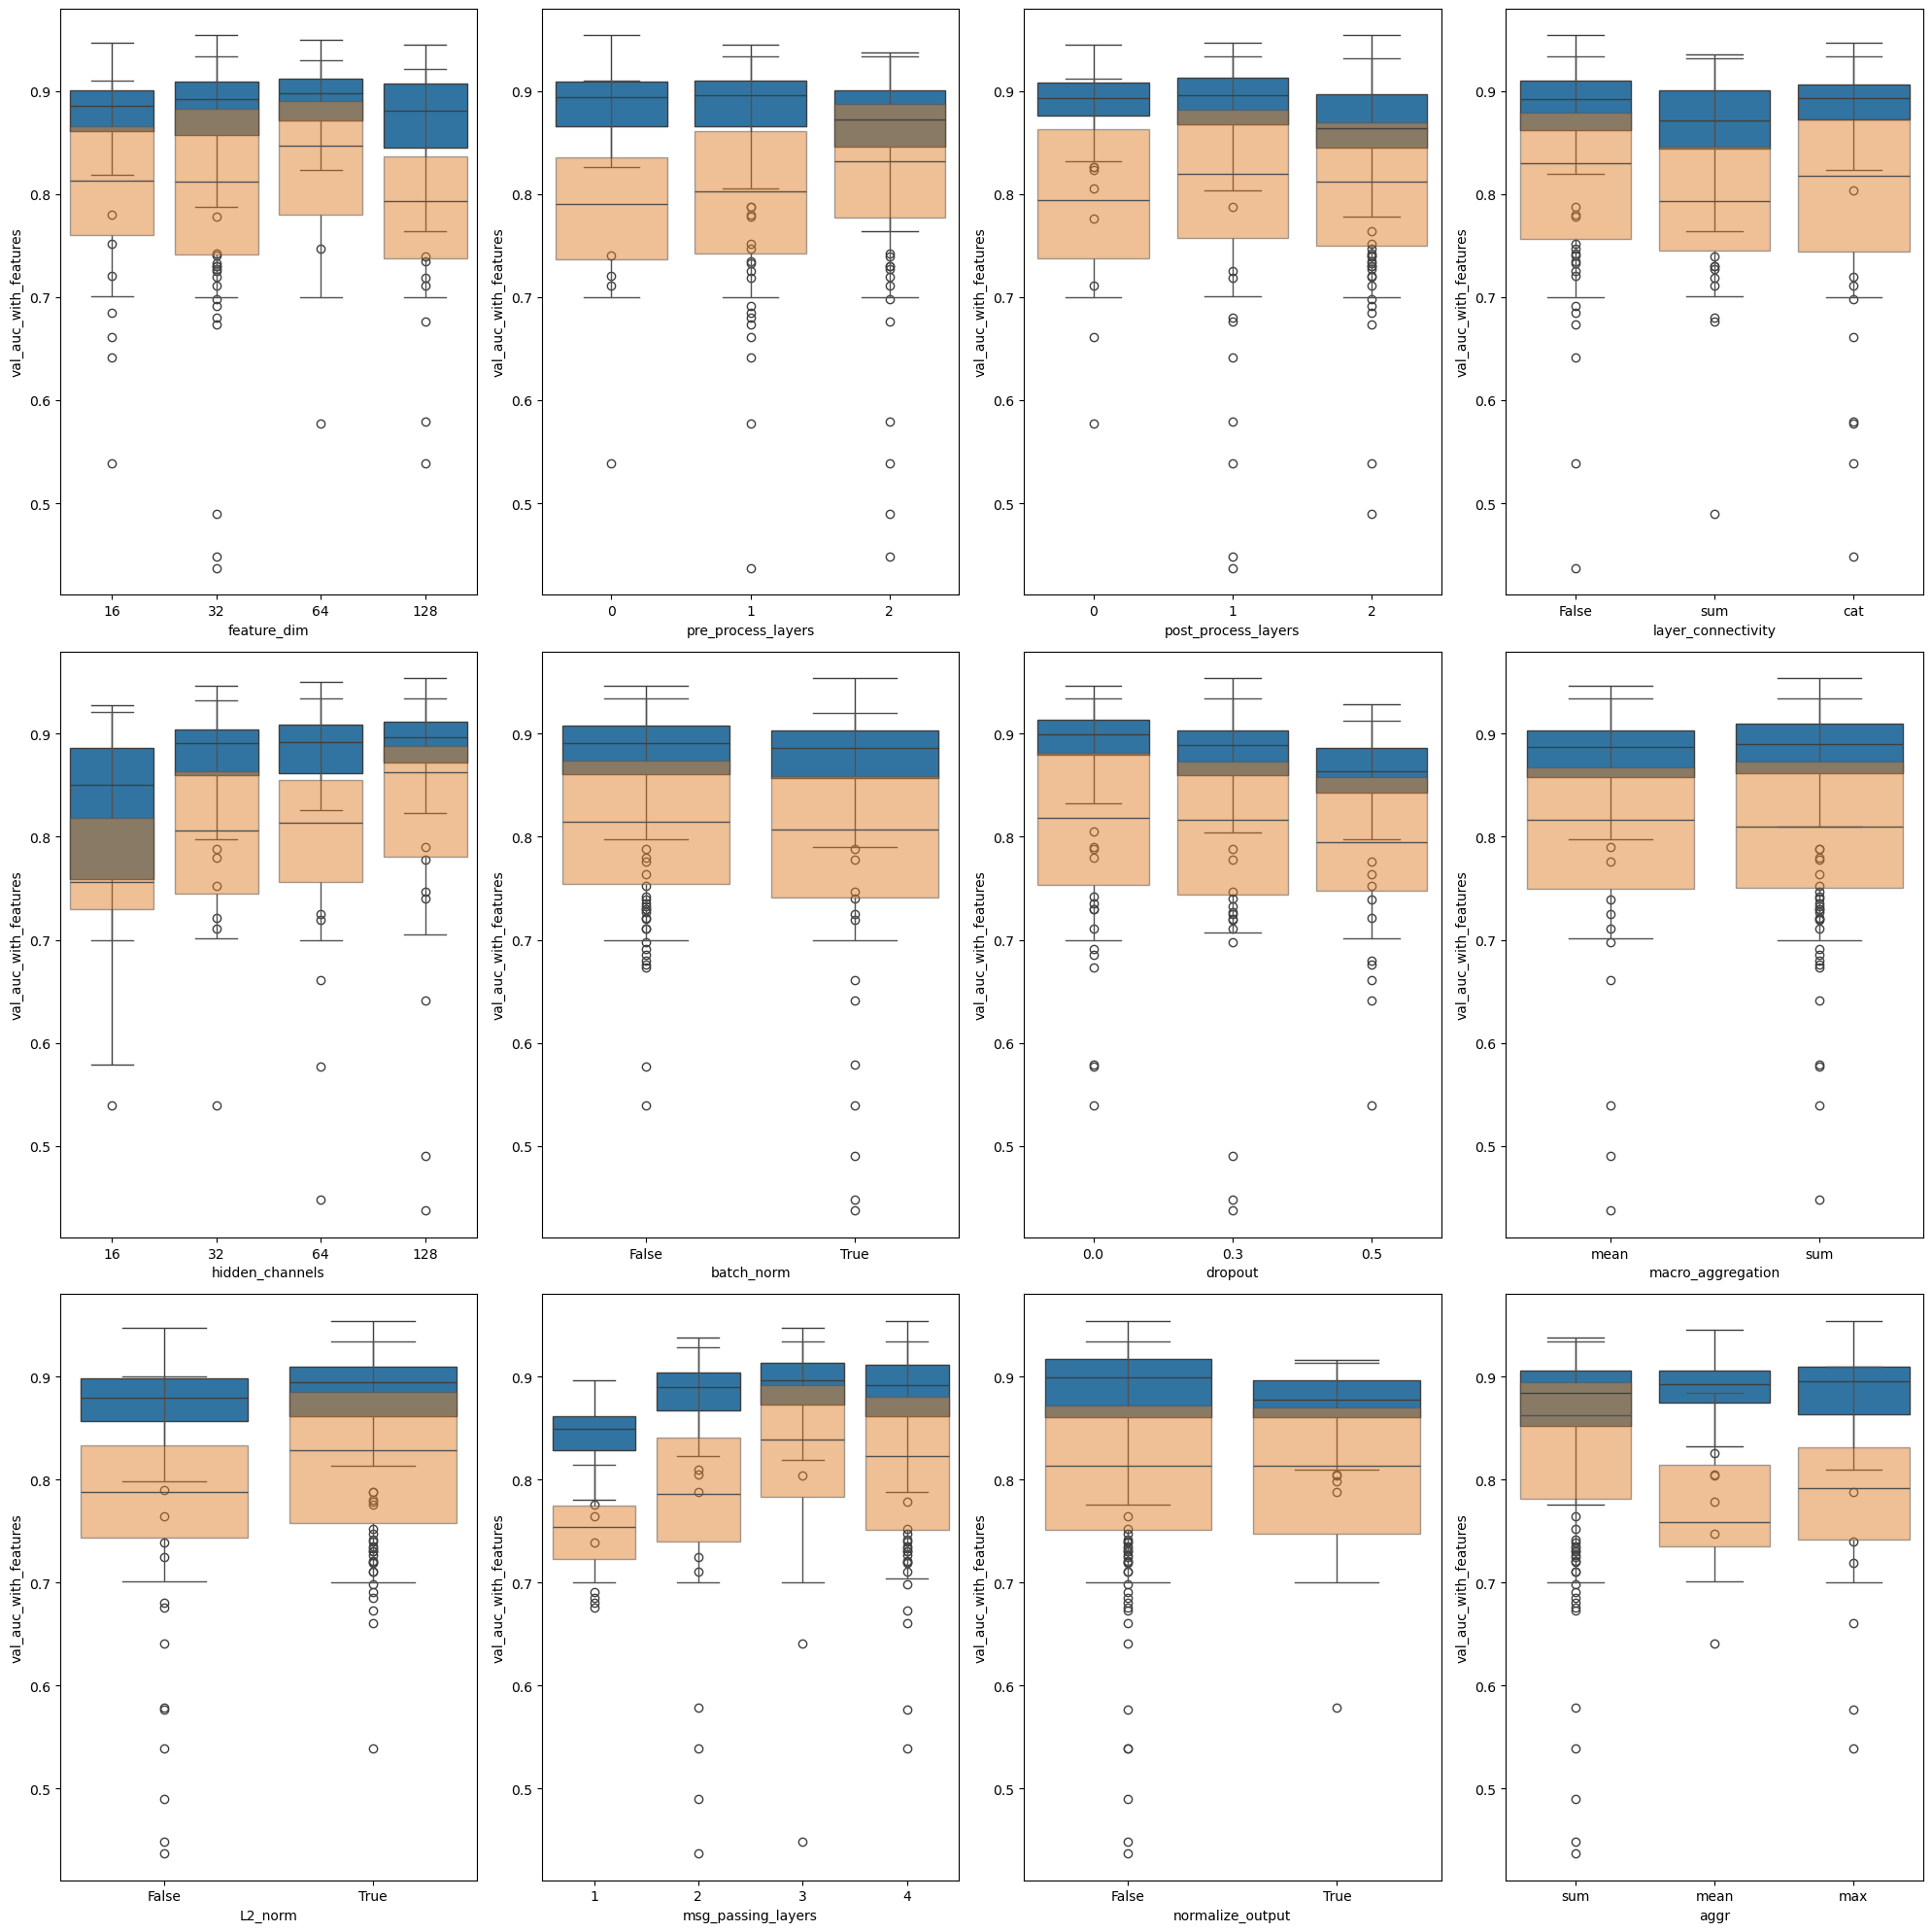

In [297]:
fig, axes = plt.subplots(3, 4, figsize=(20,20)) 
for i in range(12):
    sns.boxplot(x=hps[i], y="val_auc_with_features", data=walk_with_features, ax=axes[i//4, i%4])
    sns.boxplot(x=hps[i], y="val_auc", data=walk_with_features, ax=axes[i//4, i%4], boxprops=dict(alpha=.5))
    
plt.tight_layout()
plt.show()

In [298]:
dataset, node_map = training_utils.load_data(data_folder,load_inverted_map=False,load_test=True)

In [299]:
[(idx, random_feats_aucs[idx], go2vec_feats_aucs[idx], walk_with_features.iloc[idx]["pre_process_layers"], walk_with_features.iloc[idx]["post_process_layers"]) for idx in idxs if go2vec_feats_aucs[idx] > 0.85]

[(267, 0.7, 0.883, 0, 0),
 (122, 0.701, 0.866, 1, 1),
 (145, 0.701, 0.888, 1, 0),
 (118, 0.705, 0.895, 1, 2),
 (98, 0.705, 0.896, 1, 2),
 (254, 0.705, 0.852, 0, 2),
 (135, 0.707, 0.911, 0, 1),
 (114, 0.707, 0.875, 0, 1),
 (180, 0.708, 0.862, 0, 1),
 (133, 0.71, 0.909, 0, 2),
 (317, 0.71, 0.885, 2, 1),
 (146, 0.712, 0.888, 1, 0),
 (126, 0.716, 0.867, 1, 2),
 (67, 0.716, 0.894, 1, 0),
 (278, 0.718, 0.893, 0, 0),
 (10, 0.718, 0.945, 1, 1),
 (34, 0.719, 0.917, 0, 1),
 (108, 0.719, 0.905, 0, 1),
 (29, 0.721, 0.916, 0, 0),
 (222, 0.723, 0.852, 2, 2),
 (74, 0.723, 0.895, 0, 1),
 (170, 0.724, 0.898, 1, 0),
 (107, 0.725, 0.89, 1, 0),
 (78, 0.726, 0.924, 0, 1),
 (281, 0.726, 0.892, 0, 0),
 (127, 0.726, 0.866, 1, 2),
 (201, 0.726, 0.851, 2, 1),
 (123, 0.727, 0.861, 1, 1),
 (144, 0.727, 0.861, 0, 2),
 (214, 0.728, 0.878, 2, 1),
 (134, 0.73, 0.888, 0, 1),
 (279, 0.731, 0.892, 0, 0),
 (284, 0.731, 0.888, 0, 0),
 (312, 0.733, 0.873, 0, 1),
 (187, 0.734, 0.852, 1, 0),
 (171, 0.734, 0.905, 1, 0),
 (141

In [300]:
# agarramos para probar el 10: paso de 0.718 a 0.945

example = walk_with_features.iloc[133][1:]
example 

weight_decay              0.001
lr                        0.001
epochs                      500
patience                     10
delta                       0.1
feature_dim                 128
features                 random
pre_process_layers            0
post_process_layers           2
layer_connectivity        False
hidden_channels              16
batch_norm                 True
dropout                     0.0
macro_aggregation           sum
L2_norm                    True
msg_passing_layers            2
normalize_output          False
aggr                        max
val_auc                    0.71
accepted                   True
val_auc_with_features     0.909
Name: 133, dtype: object

In [301]:
param_keys = [["weight_decay","lr","epochs","patience","delta","feature_dim","features"],
              ["pre_process_layers","post_process_layers", "layer_connectivity", "hidden_channels",
               "batch_norm", "dropout","macro_aggregation","L2_norm","msg_passing_layers","normalize_output"],
              ["aggr"]
              ]

In [302]:
example_params = example[:-3].to_dict()

In [303]:
# permutamos al azar las features
feature_tensor, tensor_idxs = gene_feature_dict["gene"]
perm_idxs = np.random.choice(dataset[0]["gene"].num_nodes, tensor_idxs.shape[0])
perm_feature_dict = {"gene":[feature_tensor, perm_idxs]}

In [310]:
def loss_evol(params: dict, curve_random, curve_feat, curve_perm_feat):
    fig, axes = plt.subplots(1,3,figsize=(15,6), sharex=True, sharey=True)

    epochs = range(params["epochs"])
    axes[0].plot(epochs, curve_random[0])
    axes[0].plot(epochs, curve_random[1])
    axes[0].set_title("Random")


    axes[1].plot(epochs, curve_feat[0])
    axes[1].plot(epochs, curve_feat[1])
    axes[1].set_title("features")

    axes[2].plot(epochs, curve_perm_feat[0], label="train loss")
    axes[2].plot(epochs, curve_perm_feat[1], label="val loss")
    axes[2].set_title("perm features")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [311]:
def auc_evol(capas, rand_layers_aucs, feat_layers_aucs, perm_feat_layers_aucs):
    plt.figure(figsize=(10,6))
    plt.plot(capas, rand_layers_aucs, label="features random")
    plt.plot(capas[1:], feat_layers_aucs, label="features")
    plt.plot(capas[1:], perm_feat_layers_aucs, label="features permutadas")
    plt.xlabel("Capas del modelo")
    plt.ylabel("val auc")
    plt.title("Evolucion de auc a traves del modelo")
    plt.legend()
    plt.show()

In [312]:
def plot_scores_evol(capas, pos_scores, neg_scores):
    n=len(pos_scores)

    if n < 4:
        rows, cols = 1, 3
    elif n <= 6:
        rows, cols = 2, 3
    else:  # n == 7, init_features, pre_mlp, 4 convs, post_mlp
        rows, cols = 3, 3

    fig, axes = plt.subplots(rows,cols,figsize=(14,6))

    axes = np.array(axes).reshape(rows, cols)

    for i in range(len(pos_scores)):
        sns.histplot(pos_scores[i], bins=50, label="pos", ax=axes[i//cols, i%cols])
        sns.histplot(neg_scores[i], bins=50, label="neg",alpha=0.3, ax=axes[i//cols, i%cols])
        axes[i//cols, i%cols].set_title(capas[i+(len(pos_scores)==len(capas)-1)])
        axes[i//cols, i%cols].legend()

    for i in range(n, rows*cols):
        axes[i//cols, i%cols].axis('off')
        
    plt.tight_layout()
    plt.show()

In [313]:
def model_evol(params:dict, return_data=False):
    """
    utility to compare different configurations.
    trains 3 model on params (random features, go2vec features, permuted go2vec features) and plots model's evolution: 
    train/val curves, auc through layers, positive and negative scores distributions through layers.

    params: model hyperparameters to be trained on
    
    return_data: if set to True, returns a dict where keys are the three models and values are tuples of
                  (model, val_data, layer_encodings, layer_positive_scores, layer_negative_scores).
    """

    model_random, curve_random, val_auc_random, data_random = explor_utils.init_train_eval(dataset, params, param_keys)

    model_feat, curve_feat, val_auc_feat, data_feat = explor_utils.init_train_eval(dataset, params, param_keys, gene_feature_dict)

    model_perm_feat, curve_perm_feat, val_auc_perm_feat, data_perm_feat = explor_utils.init_train_eval(dataset, params, param_keys, perm_feature_dict)

    
    print(f"val_auc no features:{val_auc_random}\n")
    print(f"val_auc features:{val_auc_feat}\n")
    print(f"val_auc perm features:{val_auc_perm_feat}")

    loss_evol(params, curve_random, curve_feat, curve_perm_feat)

    val_rand, val_feat, val_perm_feat = data_random[1].to("cpu"), data_feat[1].to("cpu"), data_perm_feat[1].to("cpu")

    rand_layers_encodings = explor_utils.get_layers_embeddings(model_random, val_rand)
    feat_layers_encodings = explor_utils.get_layers_embeddings(model_feat, val_feat)
    perm_feat_layers_encodings = explor_utils.get_layers_embeddings(model_perm_feat, val_perm_feat)

    rand_layers_aucs, rand_layers_pos_scores, rand_layers_neg_scores = explor_utils.layer_tests(model_random,rand_layers_encodings, val_rand)
    feat_layers_aucs, feat_layers_pos_scores, feat_layers_neg_scores = explor_utils.layer_tests(model_feat,feat_layers_encodings[1:], val_feat)
    perm_feat_layers_aucs, perm_feat_layers_pos_scores, perm_feat_layers_neg_scores = explor_utils.layer_tests(model_perm_feat,
                                                                                                               perm_feat_layers_encodings[1:], val_perm_feat)
    
    capas = ["init features"]
    if params["pre_process_layers"]>0:
        capas.append("pre-mlp")
    for i in range(1,params["msg_passing_layers"]+1):
        capas.append(f"conv{i}")
    if params["post_process_layers"]>0:
        capas.append("post-mlp")

    auc_evol(capas, rand_layers_aucs, feat_layers_aucs, perm_feat_layers_aucs)

    plot_scores_evol(capas, rand_layers_pos_scores, rand_layers_neg_scores)
    plot_scores_evol(capas, feat_layers_pos_scores, feat_layers_neg_scores)
    plot_scores_evol(capas, perm_feat_layers_pos_scores, perm_feat_layers_neg_scores)

    returns = {"random":(model_random, val_rand, rand_layers_encodings, rand_layers_pos_scores, rand_layers_neg_scores),
                "features": (model_feat, val_feat, feat_layers_encodings, feat_layers_pos_scores, feat_layers_neg_scores),
                "perm_features": (model_perm_feat, val_perm_feat, perm_feat_layers_encodings, perm_feat_layers_pos_scores, perm_feat_layers_neg_scores)}
               

    if return_data:
        return returns

In [314]:
import warnings
warnings.filterwarnings("ignore")

val_auc no features:0.73

val_auc features:0.894

val_auc perm features:0.868


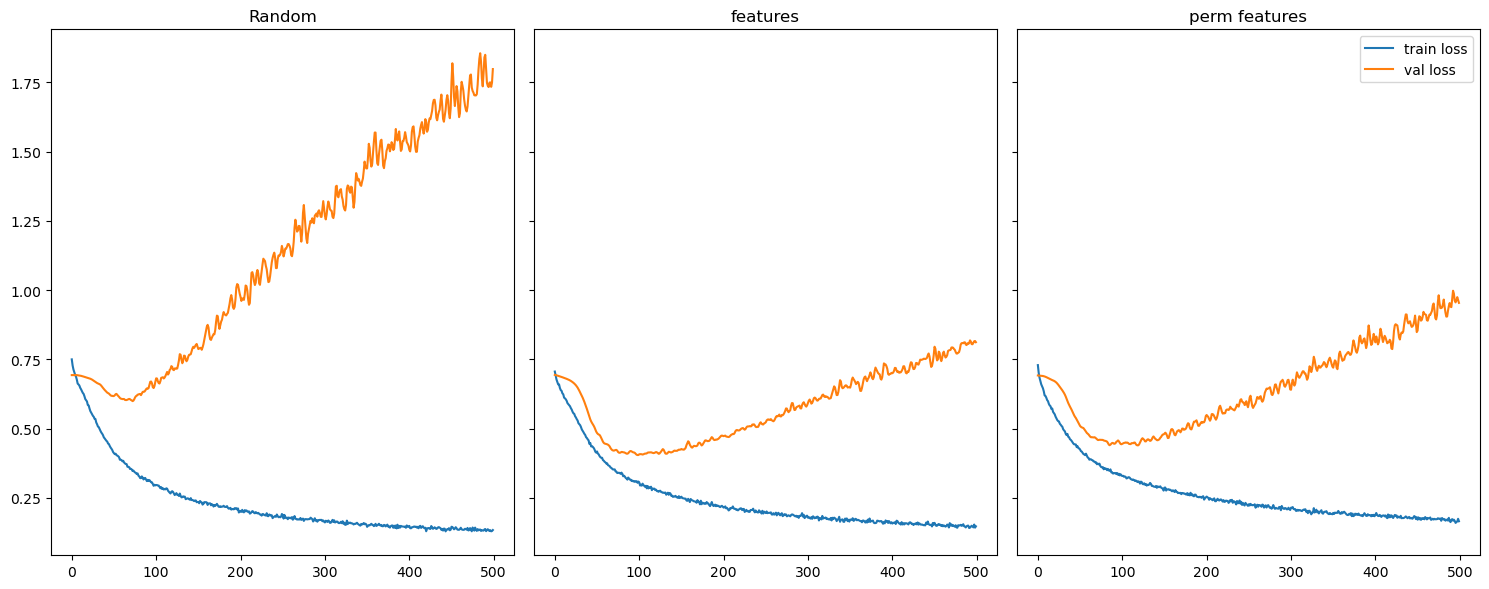

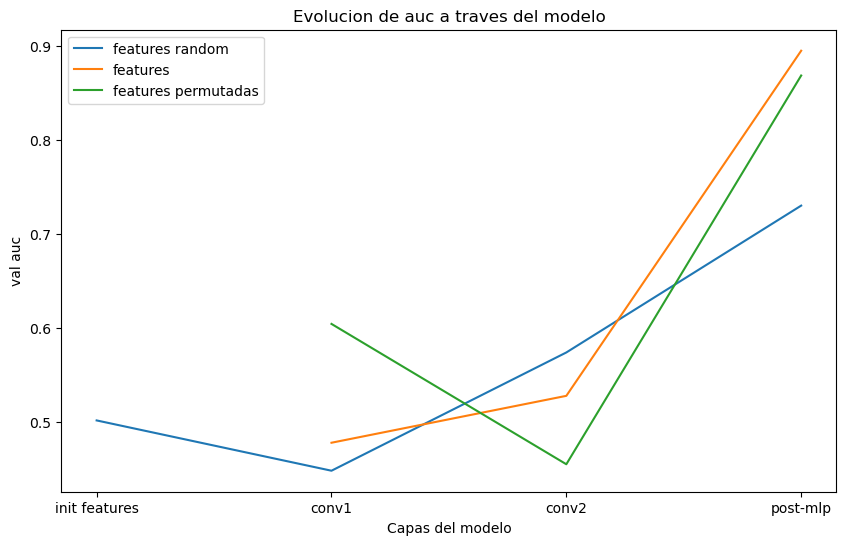

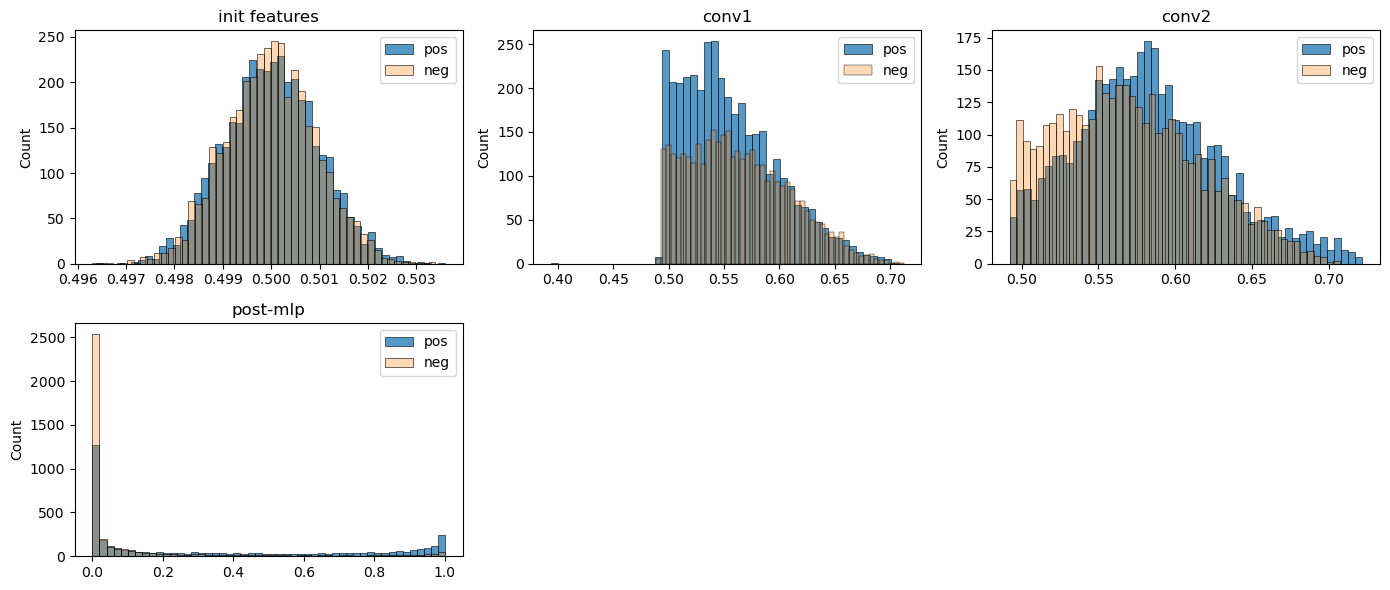

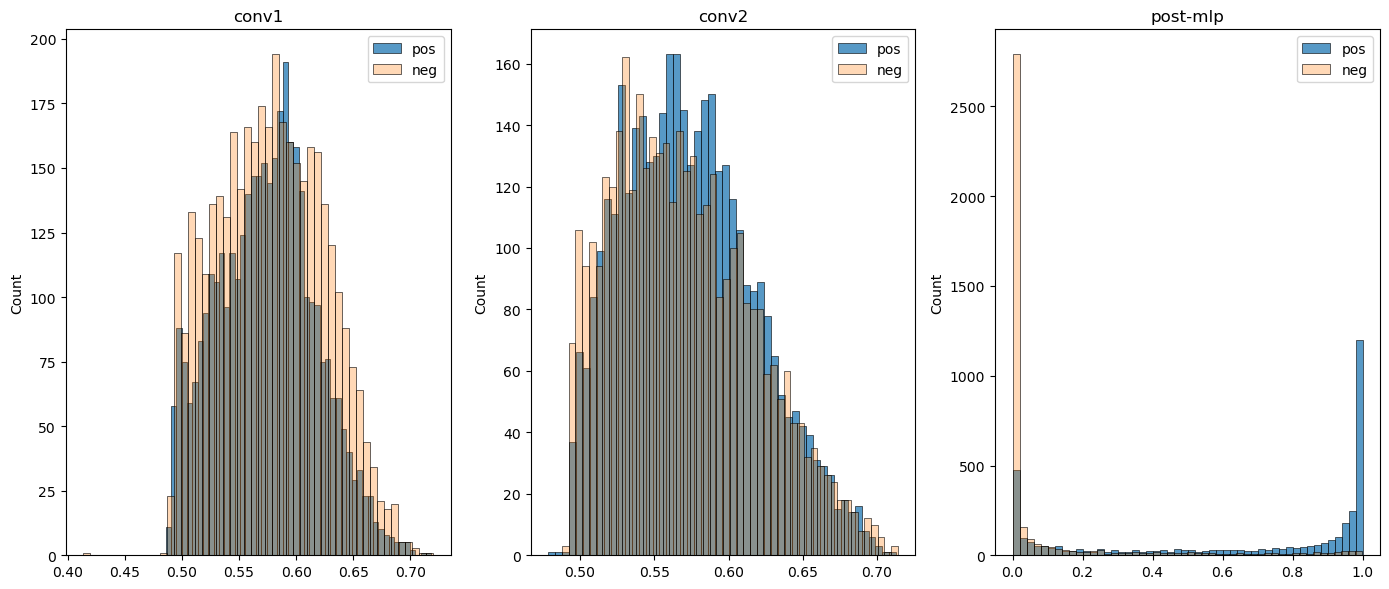

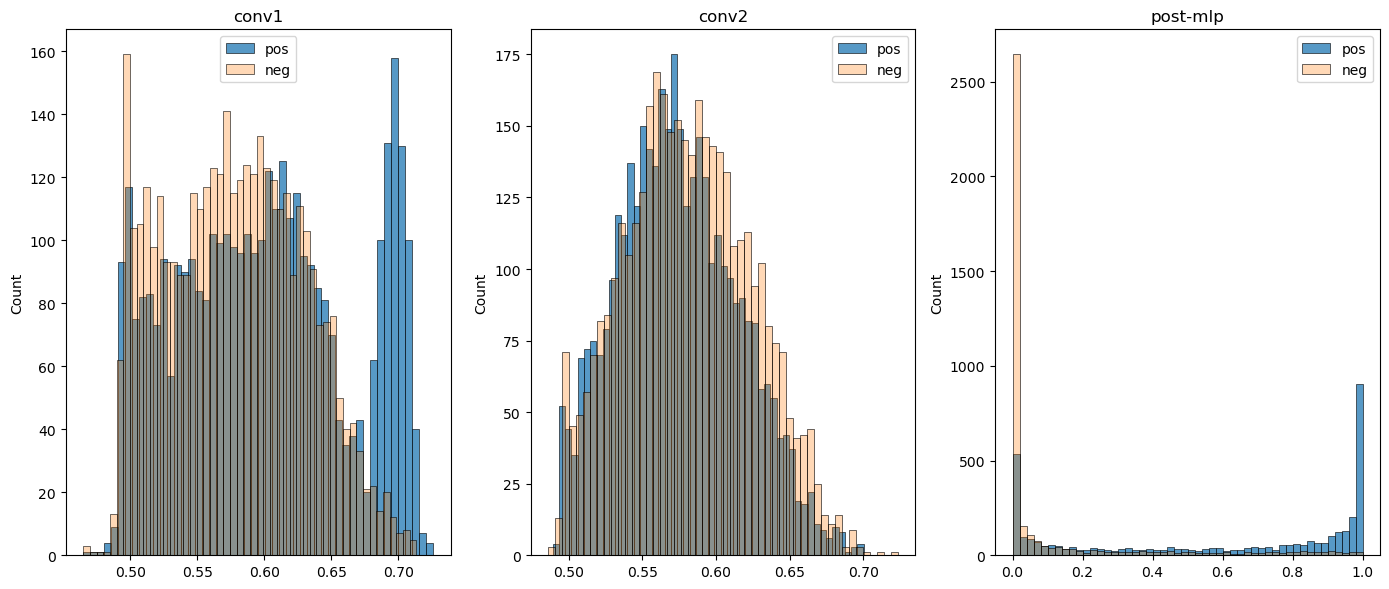

In [315]:
model_evol(example_params)

In [316]:
example_2 = walk_with_features.iloc[29][1:]
example_2

weight_decay              0.001
lr                        0.001
epochs                      400
patience                     10
delta                       0.1
feature_dim                  16
features                 random
pre_process_layers            0
post_process_layers           0
layer_connectivity          cat
hidden_channels             128
batch_norm                 True
dropout                     0.5
macro_aggregation          mean
L2_norm                    True
msg_passing_layers            4
normalize_output           True
aggr                        sum
val_auc                   0.721
accepted                   True
val_auc_with_features     0.916
Name: 29, dtype: object

In [317]:
example_2_params = example_2[:-3].to_dict()

val_auc no features:0.593

val_auc features:0.912

val_auc perm features:0.907


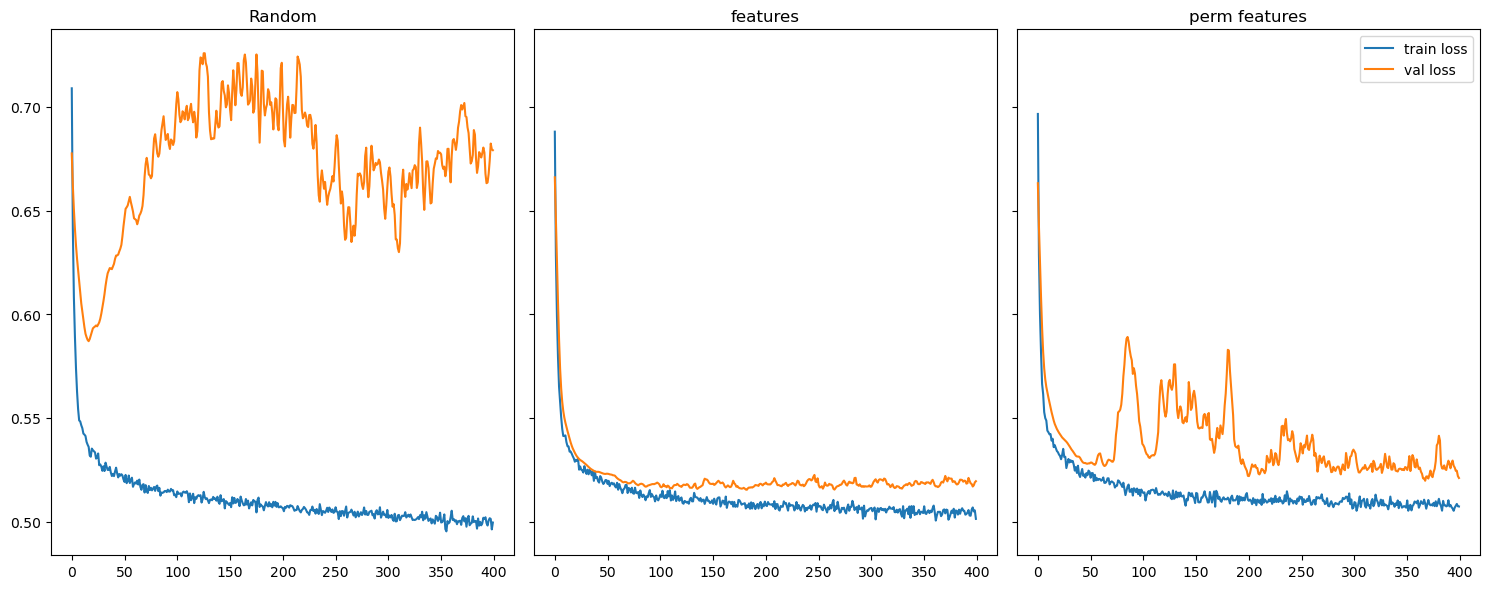

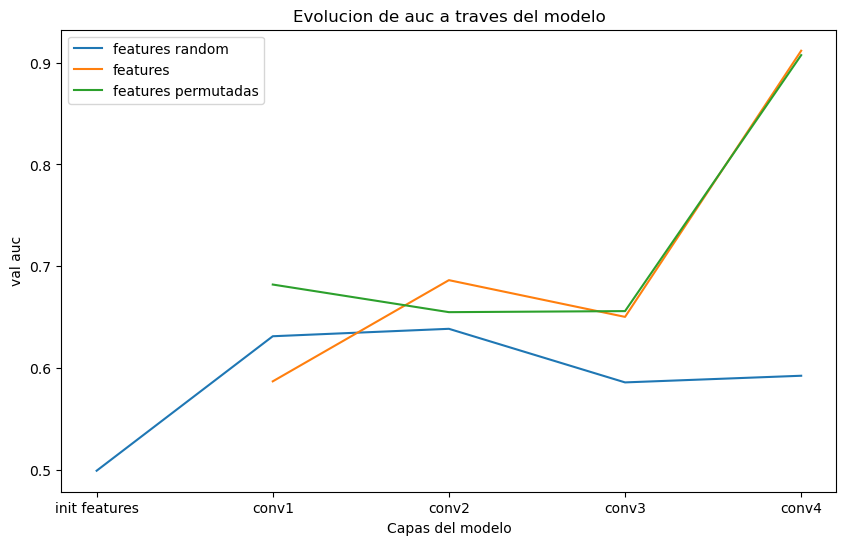

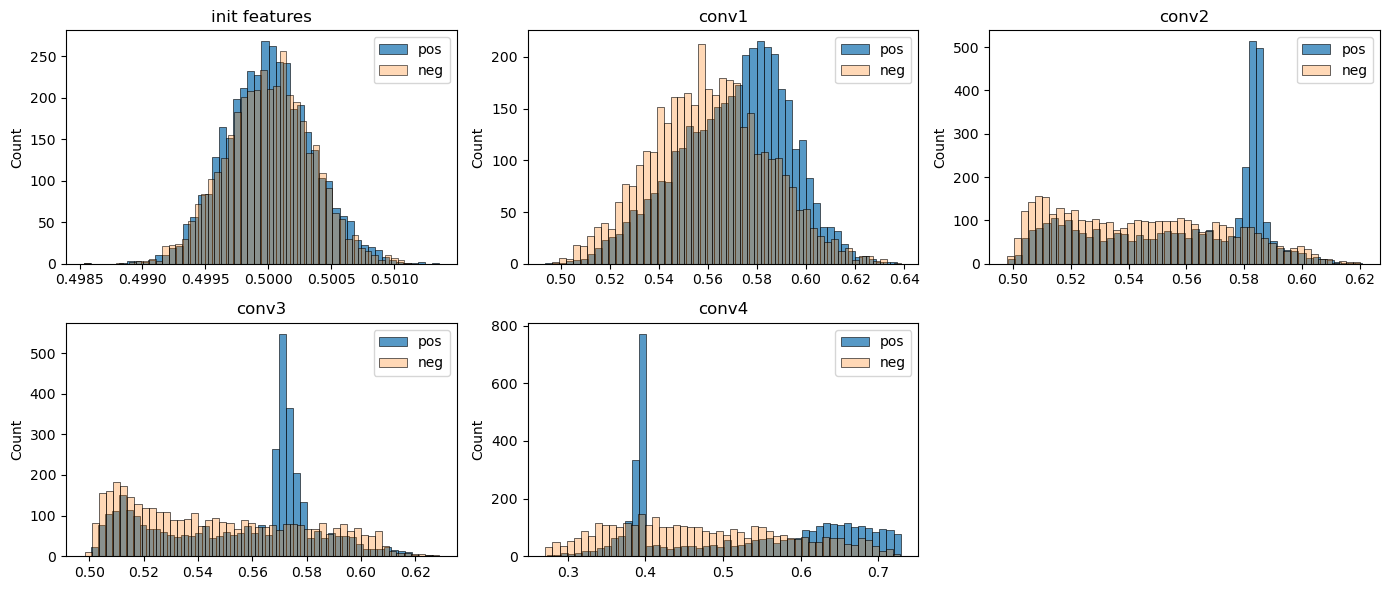

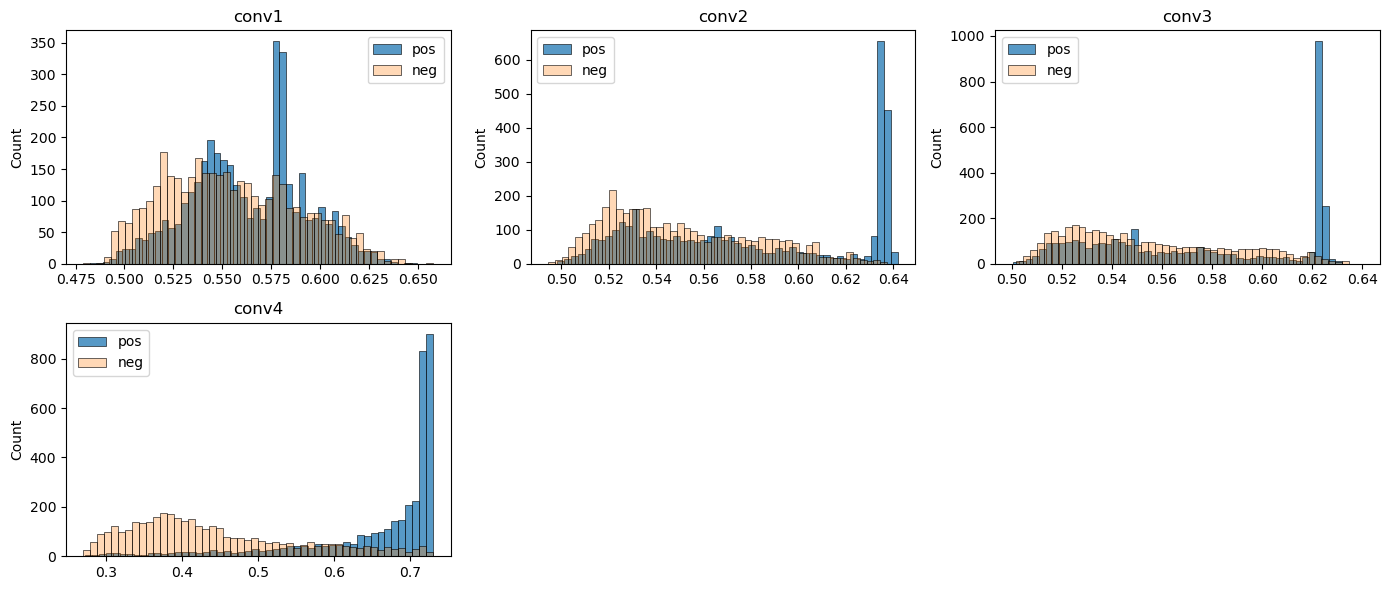

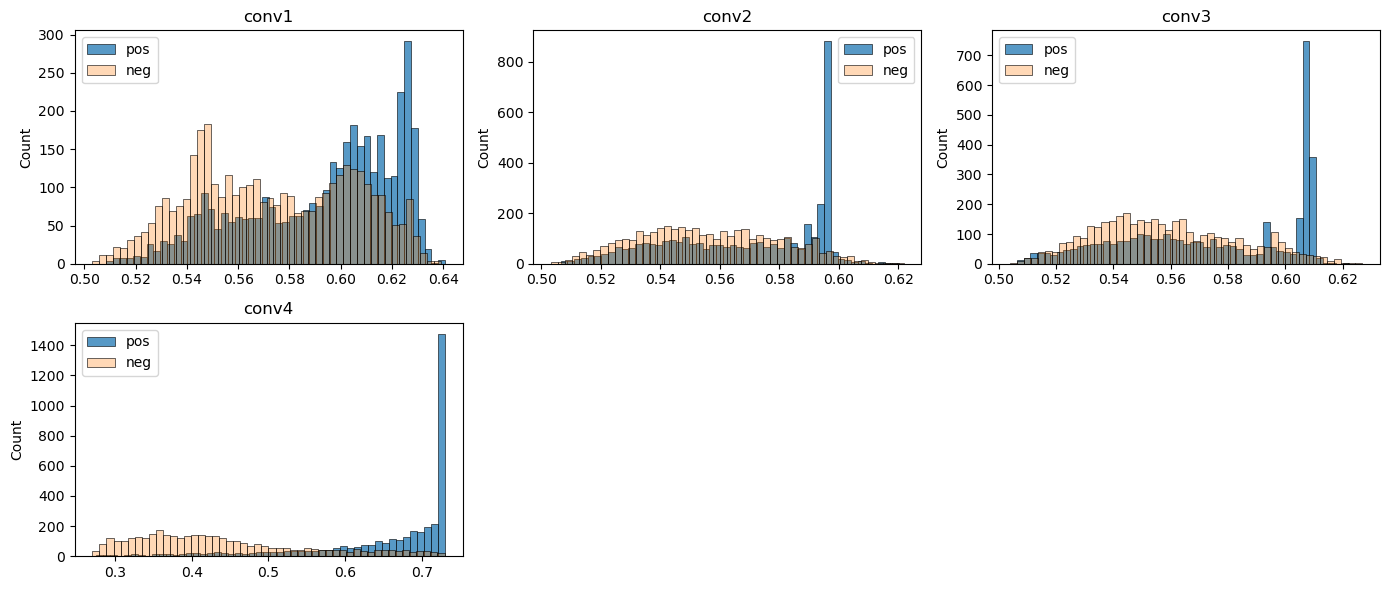

In [318]:
data_model_2 = model_evol(example_2_params, return_data=True)

Necesito buscar algun tipo de estadistica que sea invariante ante permutaciones para chequear bien que onda...
Pero primero, aprenden "lo mismo" los modelos permutados? Podemos ver varias cosas:
1. diferencia entre las predicciones finales (distribucion de ||score-score_perm|| o ordenamos uno y ploteamos el otro con ese ordenamiento)
2. diferencia entre los embeddings finales (nodo a nodo)
3. cuanto de los k-nn finales comparten (tanto general, para un mismo tipo de nodo, o para el contrario) (pensar si no es mejor ver distribucion de MRR: ordeno los vecinos del modelo sin permutar, veo donde me quedan en el permutado y caluclo MRR)
4. para cada nodo, agarrar los vecinos de la capa contraria y calcular la distancia media entre estos. Hacer esto pre y post entrenamiento y ver la distribucion. Comparar entre el modelo original y el permutado

In [319]:
data_random, data_feat, data_perm_feat = data_model_2["random"], data_model_2["features"], data_model_2["perm_features"]

encodings_random, encodings_feat, encodings_perm_feat = data_random[2], data_feat[2], data_perm_feat[2]
final_emb_random, final_emb_feat, final_emb_perm_feat = encodings_random[-1], encodings_feat[-1], encodings_perm_feat[-1]

pos_scores_random, pos_scores_feat, pos_scores_perm_feat = data_random[3], data_feat[3], data_perm_feat[3]
neg_scores_random, neg_scores_feat, neg_scores_perm_feat = data_random[4], data_feat[4], data_perm_feat[4]

1.

In [320]:
final_scores_feat = np.concatenate((pos_scores_feat[-1], neg_scores_feat[-1]))
final_scores_perm_feat = np.concatenate((pos_scores_perm_feat[-1], neg_scores_perm_feat[-1]))

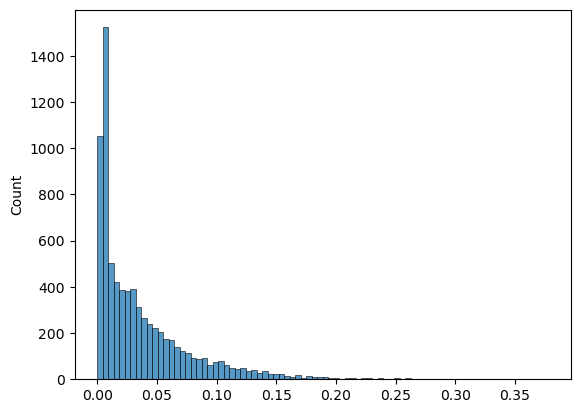

In [321]:
sns.histplot(np.abs(final_scores_feat-final_scores_perm_feat))
plt.show()

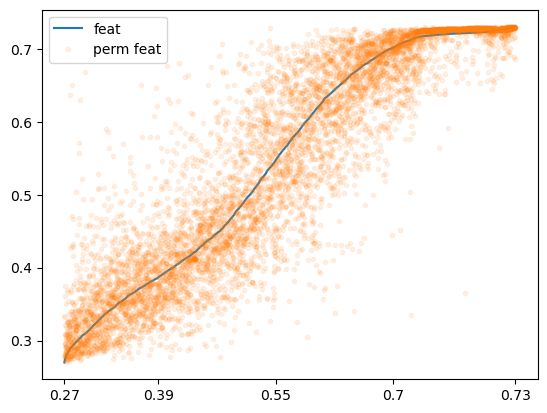

In [322]:
ordered_score_idxs = np.argsort(final_scores_feat)
plt.plot(final_scores_feat[ordered_score_idxs], label="feat")
plt.plot(final_scores_perm_feat[ordered_score_idxs], ".",alpha=0.1,label="perm feat")
plt.xticks([0,1600, 3600, 5600, len(ordered_score_idxs)], 
           labels=np.round(final_scores_feat[ordered_score_idxs][[0,1600, 3600, 5600, len(ordered_score_idxs)-1]],2))
plt.legend()
plt.show()


2.

In [323]:
norm_final_emb_feat = final_emb_feat["gene"]/torch.norm(final_emb_feat["gene"],dim=1, keepdim=True)
norm_final_emb_perm_feat = final_emb_perm_feat["gene"]/torch.norm(final_emb_perm_feat["gene"],dim=1, keepdim=True)


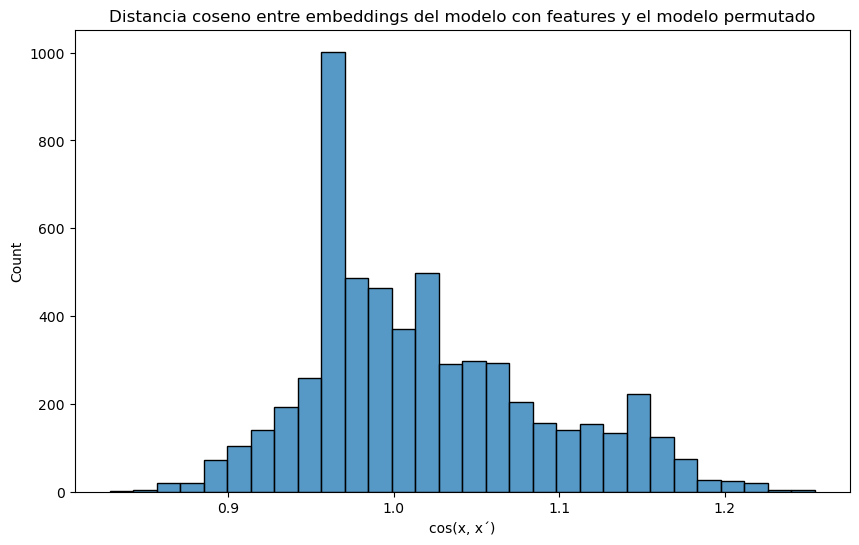

In [324]:
plt.figure(figsize=(10,6))
with torch.no_grad():
    dists = 1-torch.sum(norm_final_emb_feat*norm_final_emb_perm_feat, dim=1)
    sns.histplot(dists, bins=30)
    plt.title("Distancia coseno entre embeddings del modelo con features y el modelo permutado")
    plt.xlabel("cos(x, x´)")
    plt.show()

Casi todos perpendiculares entre si...

3. Cuanto de los k-nn finales comparten (por nodo). Para los generales y de un mismo tipo de nodo voy a usar distancia coseno, para los de la capa contraria voy a usar $\sigma(z_u \cdot z_v)$

In [325]:
def knn_intersec_plot(embs1, embs2, k, src, trgt, dist, title, ax, all_nodes=False):
    src_embs1 = embs1[src].detach()
    trgt_embs1 = embs1[trgt].detach()

    src_embs2 = embs2[src].detach()
    trgt_embs2 = embs2[trgt].detach()

    if all_nodes:
        # juntamos todos los tipos de nodo en un solo tensor
        all_embs1 = torch.cat([src_embs1,trgt_embs1],dim=0)
        all_embs2 = torch.cat([src_embs2,trgt_embs2],dim=0)
        src_embs1, trgt_embs1 = all_embs1, all_embs1
        src_embs2, trgt_embs2 = all_embs2, all_embs2

    nearest_1 = explor_utils.get_nearest_k(src_embs1, trgt_embs1, k, dist)[1]
    nearest_2 = explor_utils.get_nearest_k(src_embs2, trgt_embs2, k, dist)[1]

    intersection = [torch.isin(nearest_1[i], nearest_2[i]).sum().item() for i in range(nearest_1.shape[0])]

    sns.histplot(intersection, bins=list(range(k+1)), ax=ax)
    ax.set_title(title)
    ax.set_xlabel("interseccion de 10 vecinos mas cercanos en espacio de embeddings")

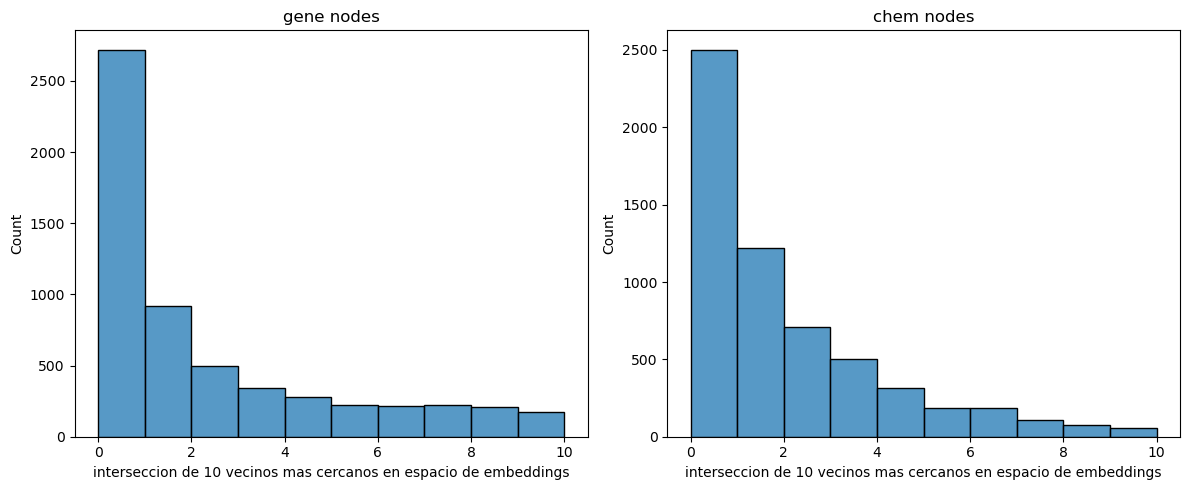

In [326]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
knn_intersec_plot(final_emb_feat, final_emb_perm_feat, 10,"gene","gene", "cos", "gene nodes", axes[0])
knn_intersec_plot(final_emb_feat, final_emb_perm_feat, 10,"chem","chem", "cos", "chem nodes", axes[1])
plt.tight_layout()
plt.show()


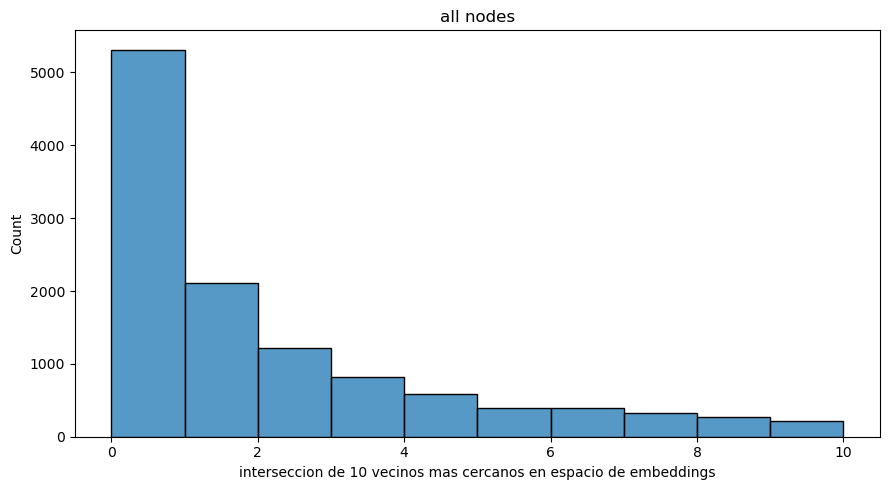

In [327]:
fig, axes = plt.subplots(1,1,figsize=(9,5))
knn_intersec_plot(final_emb_feat, final_emb_perm_feat, 10,"gene","chem", "cos", "all nodes", axes,all_nodes=True)
plt.tight_layout()
plt.show()

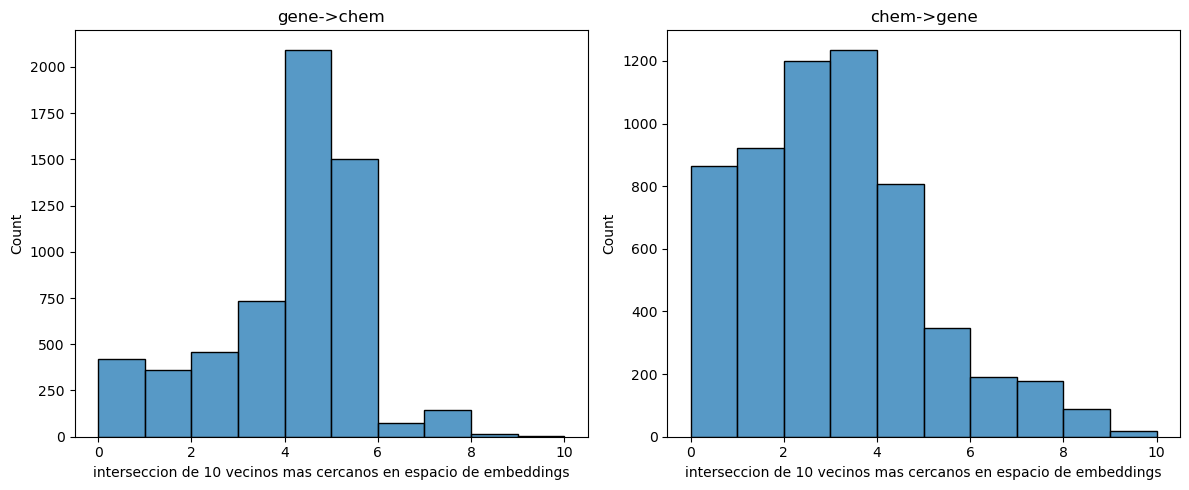

In [328]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
knn_intersec_plot(final_emb_feat, final_emb_perm_feat, 10,"gene","chem", "cos", "gene->chem", axes[0])
knn_intersec_plot(final_emb_feat, final_emb_perm_feat, 10,"chem","gene", "cos", "chem->gene", axes[1])

plt.tight_layout()
plt.show()

Como permute los genes al modelo permutado le cuesta mas aprender los vecindarios finales quimico ->[gen] ?

In [33]:
def rank_dif_hist(embs1, embs2, dist, src, trgt, all_nodes=False):
    src_embs1 = embs1[src].detach()
    trgt_embs1 = embs1[trgt].detach()

    src_embs2 = embs2[src].detach()
    trgt_embs2 = embs2[trgt].detach()

    nearest_1 = explor_utils.get_nearest_k(src_embs1, trgt_embs1, trgt_embs1.shape[0], dist)[0]
    nearest_2 = explor_utils.get_nearest_k(src_embs2, trgt_embs2, trgt_embs2.shape[0], dist)[0]

    difs = []
    for i in range(nearest_1.shape[0]):
        idxs_1, idxs_2 = torch.where(nearest_1[i].unsqueeze(1)==nearest_2[i])
        dif = abs(idxs_1-idxs_2)
        weights = np.sqrt(1/(torch.arange(1,dif.shape[0]+1)))
        w_dif = (dif*weights).sum().item()/dif.shape[0]
        difs.append(w_dif)
    sns.histplot(difs)

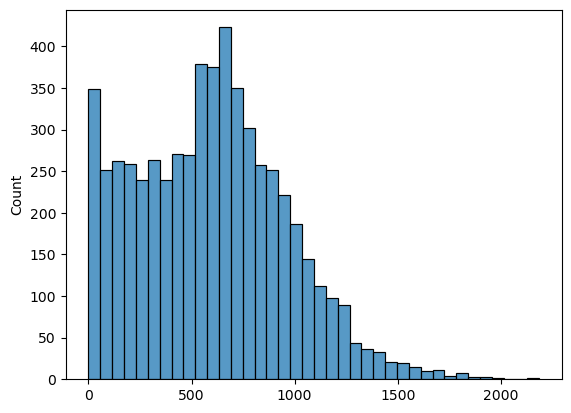

In [149]:
rank_dif_hist(final_emb_feat, final_emb_perm_feat, "cos", "gene", "chem")

4.
Vemos la evolucion (antes y desp de entrenar) de la distancia media de vecindario quimico->[gen] (gen->[quimico] no tiene sentido porque los quimicos siempre arrancan random, no hay contra que comparar. De todas formas lo random arranca todo cerca de todo.) para los 3 modelos. Yo esperaria que los vecindarios quimico->[gen] no cambien tanto pre y post entrenamiento en el modelo con features que en el modelo random. 

In [329]:
full_dataset = torch.load(data_folder+"dti_full_dataset.pt")

In [330]:
gene_to_drug_adjdict = explor_utils.get_edgetype_adjdict(("gene","chg","chem"), full_dataset)
drug_to_gene_adjdict = explor_utils.get_edgetype_adjdict(("chem","chg","gene"), full_dataset)

In [331]:
val_data_rand = data_random[1].x_dict
val_data_feat = data_feat[1].x_dict
val_data_perm_feat = data_perm_feat[1].x_dict

In [332]:
def trgt_neighbors_dist_hist(adjdict, trgt, embs, plt_params, ax):
    
    trgt_embeddings = embs[trgt]
    mean_distances = []
    for node, neighs in adjdict.items():
        if len(neighs) == 0:
            continue
        neigh_embeddings = trgt_embeddings[neighs]
        pairwise_neigh_dists = explor_utils.cos_dist_matrix(neigh_embeddings, neigh_embeddings).triu(diagonal=1)
        mean_neigh_dists = torch.cat([pairwise_neigh_dists[i,i+1:] for i in range(pairwise_neigh_dists.shape[0])]).mean().item()
        mean_distances.append(mean_neigh_dists)
    if ax is None:
        ax = plt.gca()
    sns.histplot(mean_distances, bins = 50, kde=True, ax=ax,**plt_params)
    ax.set_xlabel(f"mean GDA neighborhood ({trgt} nodes) feature distance (l2)")

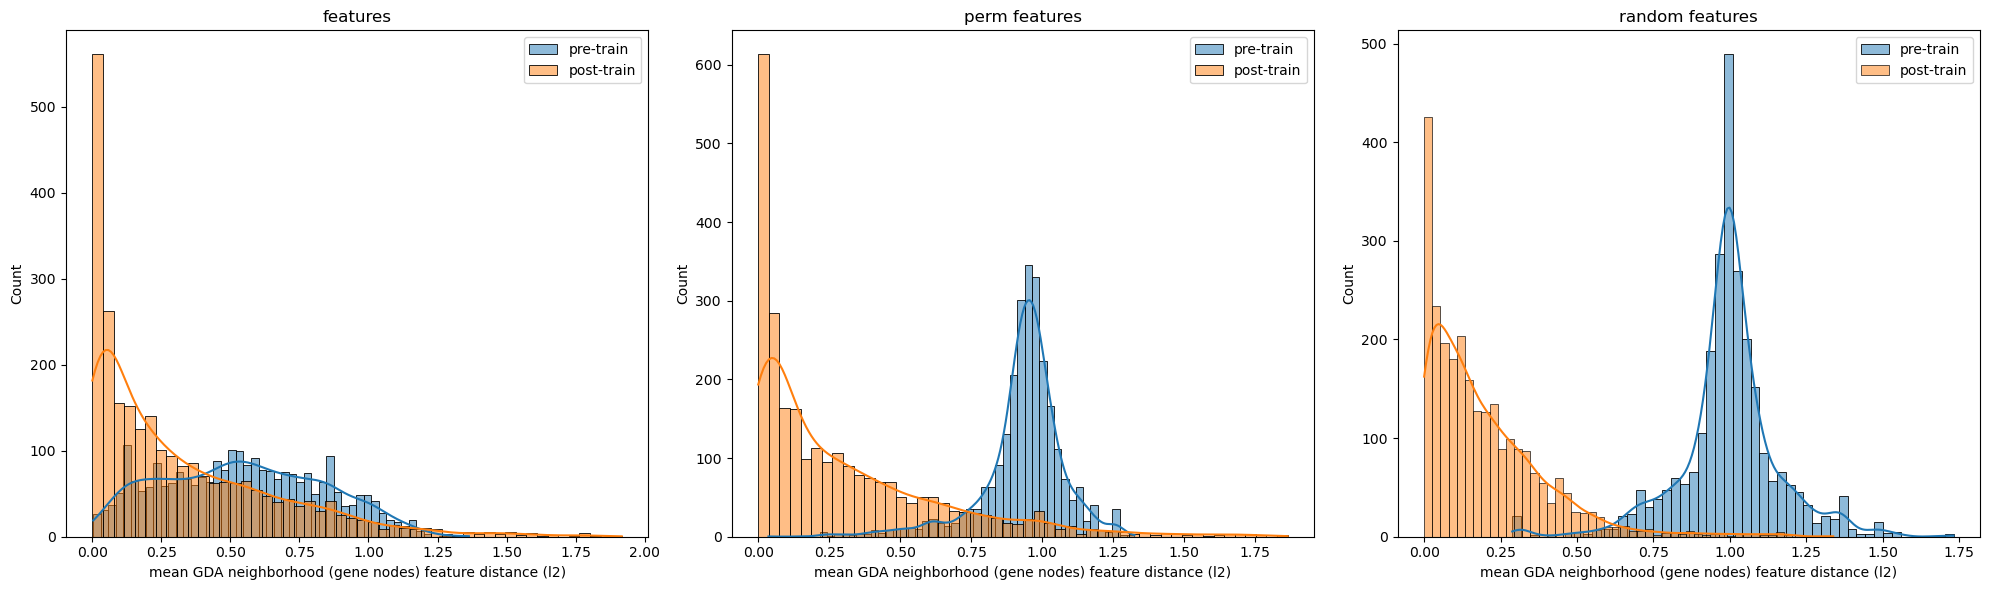

In [333]:
fig, axes = plt.subplots(1,3,figsize=(20,6))

# drug -> gene neighborhoods

trgt_neighbors_dist_hist(drug_to_gene_adjdict, "gene", val_data_feat, {"label":"pre-train"}, axes[0])
trgt_neighbors_dist_hist(drug_to_gene_adjdict, "gene", final_emb_feat, {"label":"post-train","alpha":0.5}, axes[0])
axes[0].set_title("features")
axes[0].legend()

trgt_neighbors_dist_hist(drug_to_gene_adjdict, "gene", val_data_perm_feat,  {"label":"pre-train"}, axes[1])
trgt_neighbors_dist_hist(drug_to_gene_adjdict, "gene", final_emb_perm_feat, {"label":"post-train","alpha":0.5}, axes[1])
axes[1].set_title("perm features")
axes[1].legend()

trgt_neighbors_dist_hist(drug_to_gene_adjdict, "gene", val_data_rand,  {"label":"pre-train"}, axes[2])
trgt_neighbors_dist_hist(drug_to_gene_adjdict, "gene", final_emb_random, {"label":"post-train","alpha":0.5}, axes[2])
axes[2].set_title("random features")
axes[2].legend()

plt.tight_layout()
plt.show()

Ya esto muestra que al menos en los grupos de genes conectados a una misma droga, la distancia (coseno) media permutada se parece mucho a lo random.
Esto es bueno! Aporta mas evidencia (o es lo ~mismo que el analisis de transitividad) de que genes similares tienden a conectarse con las mismas drogas pero ahora desde el punto de vista de las features.

Estaria bueno ver si las features acercan genes similares. Dado que los genes similares se conectan con aprox las mismas drogas, entonces el modelo solo tiene que aprender a mover los quimicos. La pregunta es que pasa con el modelo permutado: si se ve algo similar, podria ser indico de que permutar mantiene la relacion entre genes similares (no tendria sentido). Si no, habria que ver alguna propiedad de los nodos a escala superior que se mantenga relativamente invariante a permutaciones.

El problema de intentar chequear esto es las features random estan todas cerca de todas, entonces para ver esto bien habria que intentar verlo con clustering creo: primero, quiero ver que las features acercan genes similares y alejan disimilares (i.e, que la distancia media por cluster sea menor a la distancia media en clusters random/inter-cluster). Por ahora lo podemos intentar mirar a nivel enlace: similaridad entre los enlaces de genes segun sus features y sus featueres permutadas.

In [338]:
import copy

In [335]:
feature_idxs = gene_feature_dict["gene"][1].values
perm_feature_idxs = np.random.permutation(feature_idxs)

In [337]:
node_features_idxs = {node:i for i, node in enumerate(feature_idxs)}
perm_node_features_idxs = {node:i for i, node in enumerate(perm_feature_idxs)}

In [344]:
gene_feature_tensor = copy.deepcopy(gene_feature_dict["gene"][0])

In [345]:
gene_edge_tensor = full_dataset.edge_index_dict["gene","gg","gene"]

In [346]:
mask = torch.tensor([
    (src.item() in node_features_idxs and dest.item() in node_features_idxs)
    for src, dest in gene_edge_tensor.T
])

In [347]:
edges_with_features = gene_edge_tensor[:, mask]

In [348]:
def get_edge_feature_tensors(edge_index, normalize = True):
    """
    given edge_index of shape (2,num_edges), returns two tensors of shape (2,num_edges,feature_dim),
    where the first one corresponds to edge features (i.e features_src, features_trgt), and the second one
    to shuffled edge features. 
    
    normalize: normalize features by their L2 norm. default True.
    """
    
    src_features = gene_feature_tensor[[node_features_idxs[src.item()] for src in edge_index[0]]]
    trgt_features = gene_feature_tensor[[node_features_idxs[trgt.item()] for trgt in edge_index[1]]]

    perm_src_features = gene_feature_tensor[[perm_node_features_idxs[src.item()] for src in edge_index[0]]]
    perm_trgt_features = gene_feature_tensor[[perm_node_features_idxs[trgt.item()] for trgt in edge_index[1]]]


    if normalize:
        src_features = src_features/src_features.norm(dim=1,keepdim=True)
        trgt_features = trgt_features/trgt_features.norm(dim=1,keepdim=True)
        
        perm_src_features = perm_src_features/perm_src_features.norm(dim=1,p=2,keepdim=True)
        perm_trgt_features = perm_trgt_features/perm_trgt_features.norm(dim=1,p=2, keepdim=True)
        
    return torch.stack((src_features,trgt_features), dim=0), torch.stack((perm_src_features,perm_trgt_features),dim=0)
    
    

In [349]:
edge_features, perm_edge_features = get_edge_feature_tensors(edges_with_features)

In [350]:
def edge_cos_dist(edge_features, perm_edge_features):
    cos_edges = 1-((edge_features[0]*edge_features[1]).sum(dim=1))
    cos_edges_perm = 1-((perm_edge_features[0]*perm_edge_features[1]).sum(dim=1))
    
    return cos_edges, cos_edges_perm

In [351]:
cos_edges, cos_edges_perm = edge_cos_dist(edge_features, perm_edge_features)
ordered_cos_idxs = np.argsort(cos_edges)

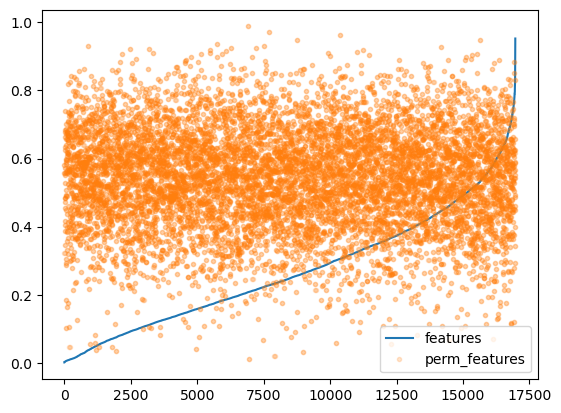

In [352]:
plt.plot(cos_edges[ordered_cos_idxs], label="features")
plt.plot(cos_edges_perm[ordered_cos_idxs], ".", alpha=0.2, label="perm_features")
plt.legend()
plt.show()

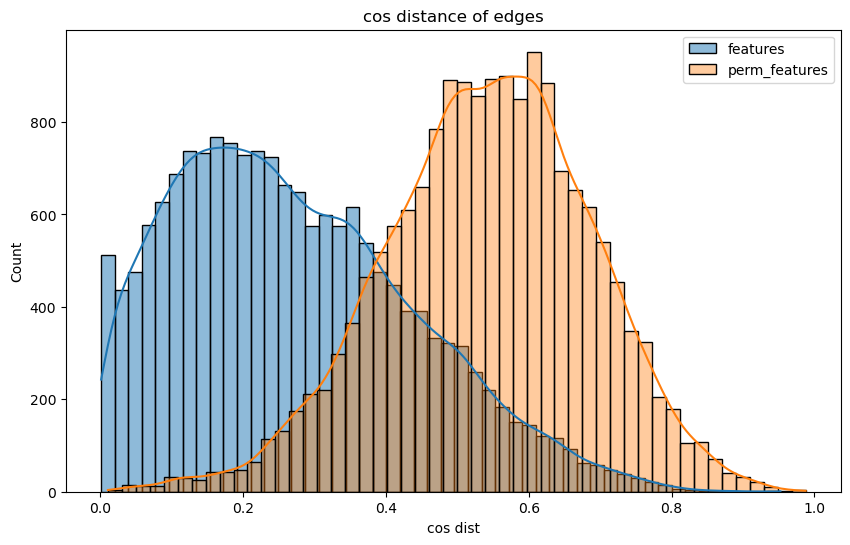

In [353]:
plt.figure(figsize=(10,6))

sns.histplot(cos_edges, bins=50, kde=True, label="features")
sns.histplot(cos_edges_perm, bins=50, kde=True, alpha=0.4,label="perm_features")

plt.xlabel("cos dist")
plt.title("cos distance of edges")
plt.legend()
plt.show()

Por completitud, genereamos aristas negativas gen-gen (donde ambos tengan features) para comparar.

In [354]:
neg_edges = []
while len(neg_edges) < edges_with_features.shape[1]:
    src = np.random.choice(feature_idxs,1).item()
    trgt = np.random.choice(feature_idxs,1).item()
    edge = torch.tensor([src,trgt])
    rev_edge = torch.tensor([trgt,src])
    
    if src != trgt and edge not in edges_with_features.T and rev_edge not in edges_with_features.T:
        neg_edges.append([src,trgt])
        neg_edges.append([trgt,src])
neg_edges = torch.tensor(neg_edges).T

In [355]:
neg_edge_features, perm_neg_edge_features = get_edge_feature_tensors(neg_edges)

In [356]:
cos_neg_edges, cos_neg_edges_perm = edge_cos_dist(neg_edge_features, perm_neg_edge_features)

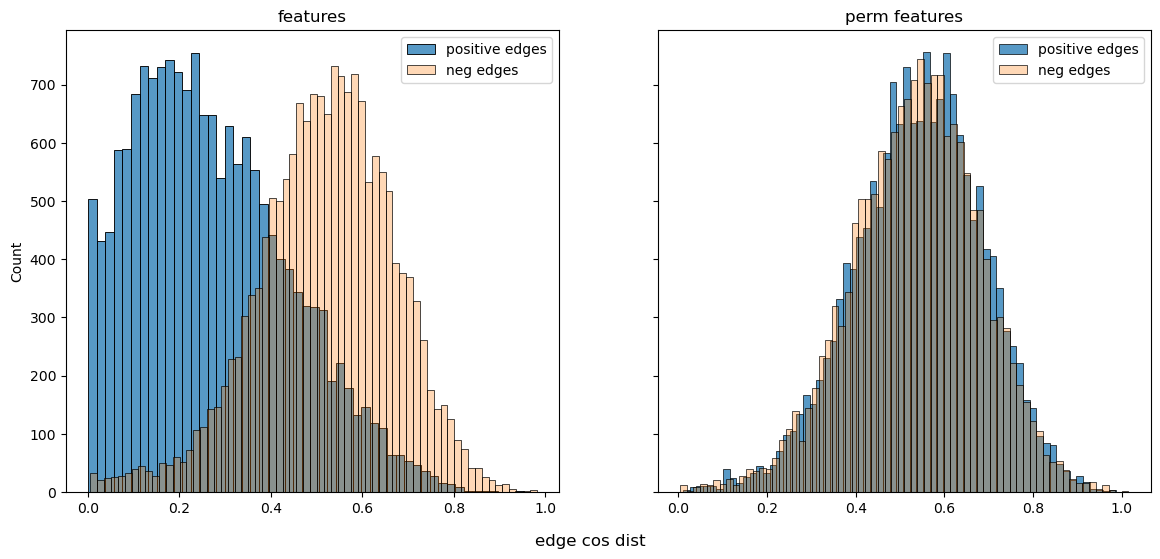

In [366]:
fig,axes = plt.subplots(1,2, figsize=(14,6), sharey=True)

sns.histplot(cos_edges, label="positive edges",ax=axes[0])
sns.histplot(cos_neg_edges, alpha=0.3,label="neg edges",ax=axes[0])
axes[0].legend()
axes[0].set_title("features")

sns.histplot(cos_edges_perm, label="positive edges",ax=axes[1])
sns.histplot(cos_neg_edges_perm, alpha=0.3,label="neg edges",ax=axes[1])
axes[1].legend()
axes[1].set_title("perm features")


fig.text(0.46, 0.02, "edge cos dist", fontsize=12)

plt.show()


Bien, las features son informativas sobre la relacion definida entre los genes tambien, y permutar rompe eso.
Recopilando:
- Las features mejoran sustancialmente la perfo de los modelos
- las features permutadas tambien, en menor medida, pero significativa de todas maneras.
- los modelos (permutado vs normal) aprenden distinto. No solo los embeddings son distintos, si no que los vecindarios finales en la misma capa tambien. Para los vecindarios de la capa DTI (que son los "aprendidos") parece haber algo mas de agreement, en particular para los gen ->[quimico].
- Las features correlacionan tanto con los vecindarios quimico->[gen] (genes asociados a los mismos quimicos tienen features similares), como con los enlaces gen-gen, y permutar las features rompe estas correlaciones. Aun asi, el modelo aprende bien.

Como sigo:
1. hacer el analisis de ablacion de las features (ir reemplazando paulatinamente por random y ver como cae la perfo y hacer la permutacion a nivel columna de los features), cerrar esta parte con lo que haya hecho. 
2. Correr los dos mejores modelos en 10 splits. Escribir el reporte de los mejores modelos junto con su perfo y la parte del analisis de hiperparametros.